## Company information

In [1]:
import pandas as pd

company_info = pd.read_csv("PriceData/US/Filtered_Data/statics_filtered_0.1_10.csv")
company_info.head()

,Type,DSCD,BDATE,ENAME,EXMNEM,GEOGN,ISIN,ISINID,LOC,PCUR,TRAC,TYPE,WC05601,CURRENCY,Delisting Date
0,69568X,69568X,2010-06-29,TESLA,NAS,UNITED STATES,US88160R1014,P,U88160R101,U$,ORD,EQ,TSLA,U$,NaN
1,902242,902242,1973-01-02,JP MORGAN CHASE & COMPANY,NYS,UNITED STATES,US46625H1005,P,U46625H100,U$,ORD,EQ,JPM,U$,NaN
2,923937,923937,1973-01-02,BANK OF AMERICA,NYS,UNITED STATES,US0605051046,P,U060505104,U$,ORD,EQ,BAC,U$,NaN
3,904282,904282,1973-01-02,COCA COLA,NYS,UNITED STATES,US1912161007,P,U191216100,U$,ORD,EQ,KO,U$,NaN
4,906195,906195,1973-01-02,WELLS FARGO & CO,NYS,UNITED STATES,US9497461015,P,U949746101,U$,ORD,EQ,WFC,U$,NaN


## Import return data

In [2]:
# import data
df = pd.read_feather("PriceData/US/Filtered_Data/Financial_base_data_panel_filtered_0.1_10.feather")
df = df.sort_values(["Date", "Stock"])

## Examine value weighted and naive portfolios

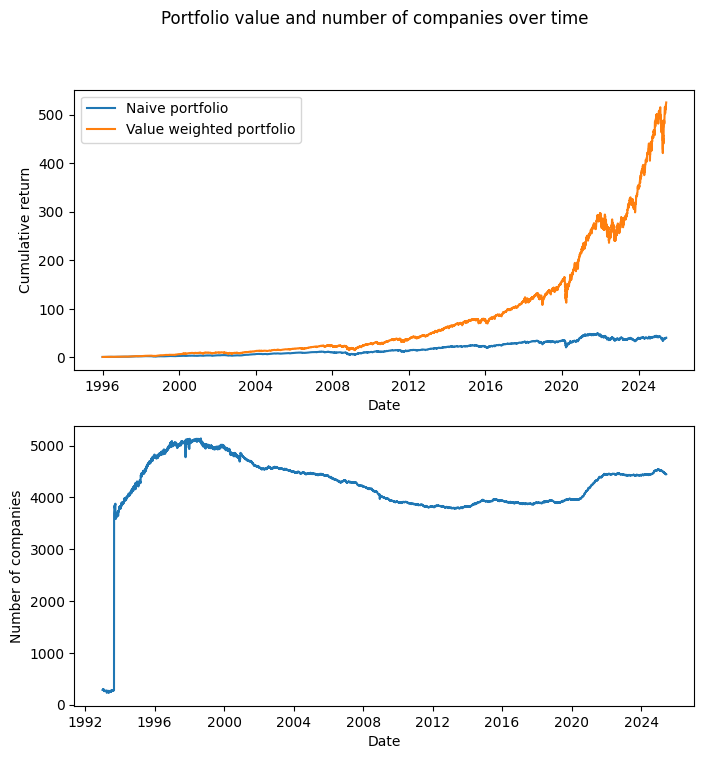

In [3]:
import matplotlib.pylab as plt

# Ensure your DataFrame is sorted by Date
df_mcap = df.loc[:, ["Date", "Stock", "MarketCAP", "Return"]]

# Step 1: Calculate total MCAP per Date
df_mcap['Total_MCAP'] = df_mcap.groupby('Date')['MarketCAP'].transform('sum')

# Step 2: Compute the weight for each stock
df_mcap['Weight'] = df_mcap['MarketCAP'] / df_mcap['Total_MCAP']

# Step 3: Compute weighted return per stock
df_mcap['Weighted_Return'] = df_mcap['Weight'] * df_mcap['Return']

# Step 4: Sum weighted returns per Date to get portfolio return
portfolio_returns = df_mcap.groupby('Date')['Weighted_Return'].sum()#.reset_index()
portfolio_returns = portfolio_returns.to_frame("MVW_PF_Return")
portfolio_returns["EW_PF_Return"] = df_mcap.groupby('Date')['Return'].mean()

cumulative_returns = portfolio_returns.add(1.).cumprod().subtract(1.)
unique_stocks_over_time = df.groupby("Date")["Stock"].nunique()


fig, axs = plt.subplots(2, 1, figsize = (8, 8))
axs[0].plot(cumulative_returns.loc["1996-01-01":]["EW_PF_Return"], label = "Naive portfolio")
axs[0].plot(cumulative_returns.loc["1996-01-01":]["MVW_PF_Return"], label = "Value weighted portfolio")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Cumulative return")
axs[0].legend()

axs[1].plot(unique_stocks_over_time)
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Number of companies")

plt.suptitle("Portfolio value and number of companies over time")
plt.show()

del df_mcap

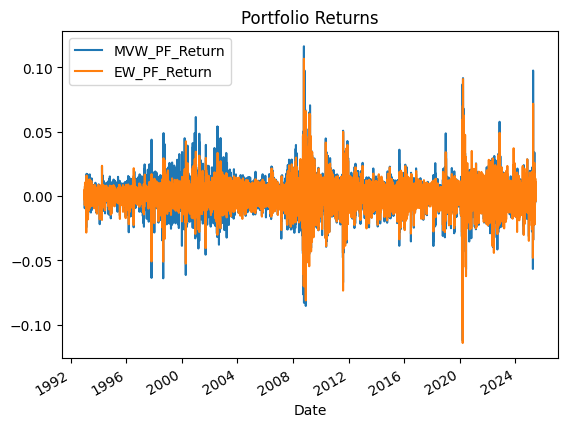

In [6]:
pf_return_plots = portfolio_returns.plot(title = "Portfolio Returns")

In [ ]:
portfolio_returns.describe()

,MVW_PF_Return,EW_PF_Return
count,8169.000000,8169.000000
mean,0.000833,0.000508
std,0.011436,0.010175
min,-0.112374,-0.114218
25%,-0.003984,-0.003738
50%,0.000982,0.001066
75%,0.006105,0.005225
max,0.116488,0.106805


In [2]:
import pandas as pd

company_info = pd.read_csv("PriceData/EU/Filtered_Data/statics_filtered_0.1_10.csv")
company_info.head()

,Type,DSCD,BDATE,ENAME,EXMNEM,GEOGN,ISIN,ISINID,LOC,PCUR,TRAC,TYPE,WC05601,CURRENCY,Delisting Date
0,756550,756550,1987-10-12,A MOKSEL DEAD - 15/08/11,FRA,GERMANY,DE0006622301,P,D662230,E,ORD,EQ,MOK,E,NaN
1,35993H,35993H,2006-05-23,ABWICKLUNGSGESELLSCHAFT BIOGAS I DEAD - DELIST...,FRA,GERMANY,DE000SBGS111,P,DSBGS11,E,ORD,EQ,SB1,E,2011-02-28
2,72994N,72994N,2010-12-14,ADC AFRICA DEVELOPMENT DEAD - 23/10/15,BER,GERMANY,DE000A1E8NW9,P,DA1E8NW,E,ORD,EQ,AZC,E,NaN
3,288501,288501,2000-03-27,ADITRON DEAD - DELIST.24/06/03,FRA,GERMANY,DE0007035107,P,D703510,E,NaN,EQ,AHG,E,2003-06-24
4,51591U,51591U,2008-01-29,AERFINANCE DEAD - 31/12/10,FRA,GERMANY,GB00B23XG900,P,DA0MY5T,E,ORD,EQ,NaN,E,NaN


In [4]:
# import data
df = pd.read_feather("PriceData/EU/Filtered_Data/Financial_base_data_panel_filtered_0.1_10.feather")
df = df.sort_values(["Date", "Stock"])

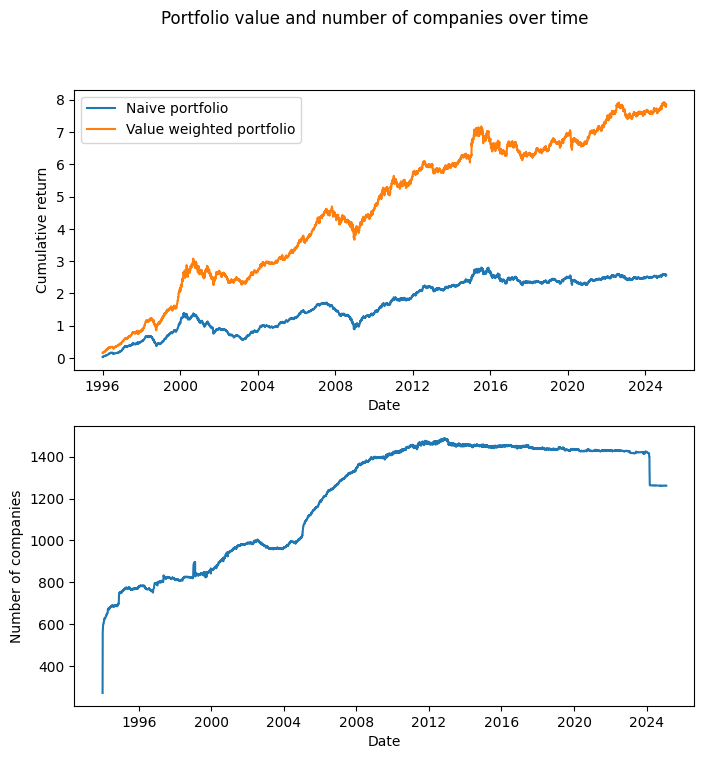

In [5]:
import matplotlib.pylab as plt

# Ensure your DataFrame is sorted by Date
df_mcap = df.loc[:, ["Date", "Stock", "MarketCAP", "Return"]]

# Step 1: Calculate total MCAP per Date
df_mcap['Total_MCAP'] = df_mcap.groupby('Date')['MarketCAP'].transform('sum')

# Step 2: Compute the weight for each stock
df_mcap['Weight'] = df_mcap['MarketCAP'] / df_mcap['Total_MCAP']

# Step 3: Compute weighted return per stock
df_mcap['Weighted_Return'] = df_mcap['Weight'] * df_mcap['Return']

# Step 4: Sum weighted returns per Date to get portfolio return
portfolio_returns = df_mcap.groupby('Date')['Weighted_Return'].sum()#.reset_index()
portfolio_returns = portfolio_returns.to_frame("MVW_PF_Return")
portfolio_returns["EW_PF_Return"] = df_mcap.groupby('Date')['Return'].mean()

cumulative_returns = portfolio_returns.add(1.).cumprod().subtract(1.)
unique_stocks_over_time = df.groupby("Date")["Stock"].nunique()


fig, axs = plt.subplots(2, 1, figsize = (8, 8))
axs[0].plot(cumulative_returns.loc["1996-01-01":]["EW_PF_Return"], label = "Naive portfolio")
axs[0].plot(cumulative_returns.loc["1996-01-01":]["MVW_PF_Return"], label = "Value weighted portfolio")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Cumulative return")
axs[0].legend()

axs[1].plot(unique_stocks_over_time)
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Number of companies")

plt.suptitle("Portfolio value and number of companies over time")
plt.show()

del df_mcap